# Meta Analysis of the Datasets for the Epi² pilot project 

---
# Cross analysis of datasets

---
# PYTHON 3 / R Notebook
### Adrien Leger / EMBL EBI
### Starting date 04/08/2016

---
## Import general package and definition of specific functions

In [1]:
# Local lib import
from pycl import *
from pyBioPlot import *

# Standard lib imports
from glob import glob
from collections import OrderedDict
import colorsys

# Third party import
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns

# Pyplot tweaking
%matplotlib inline
pl.rcParams['figure.figsize'] = 30, 10  # that's default image size for this interactive session

# Larger display 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Allow to use R directly
%load_ext rpy2.ipython

# Simplify warning reporting to lighten the notebook style 
import warnings
warnings.formatwarning=(lambda message, *args: "{}\n".format(message))

---
## Comparison RNA PTM datasets / RNA Localization at gene level

### PTM datasets
**For the moment I only have datasets at gene level from the original studies.**

In [5]:
# parsing file to get the dataset I have
d = OrderedDict()
for fp in glob("./PTM_Annotated_Datasets/*_hg38_cleaned_gencode_v24_lncRNAs_uniq-gene.csv"):
    ls = supersplit(file_name(fp), ["_", "."])    
    author = ls[0]
    ptm = ls[1]
    cell = ls[2]
    file = "_".join(ls[7:])
    
    if ptm not in d:
        d[ptm] = OrderedDict()   
    if cell not in d[ptm]:
        d[ptm][cell] = OrderedDict()
    if author not in d[ptm][cell]:
        d[ptm][cell][author] = []
    d[ptm][cell][author].append(fastcount(fp))
    
print(dict_to_report(d))

A>I
	Brain
		Sakurai:[319]
	Various
		DARNED:[1300]
		RADAR:[3343]
	YH
		Peng:[505]
Y
	HEK293
		Li:[44]
	HEK293:Fibroblast
		Schwartz:[10]
	HeLa
		Carlile:[3]
m1A
	HeLa:HEK293:HepG2
		Dominissini:[338]
m5C
	HEK293
		Hussain:[39]
	HeLa
		Squires:[112]
	MEF
		Khoddami:[36]
m6A
	HEK293
		Meyer:[16]
	HepG2
		Dominissini:[84]
m6A:m6Am
	HEK293
		Linder:[168]



**I will first try to plot all the results regardless of their cell line of origin just to see if there is any specific pattern**

using a non-integer number instead of an integer will result in an error in the future
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


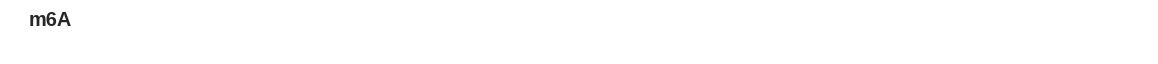

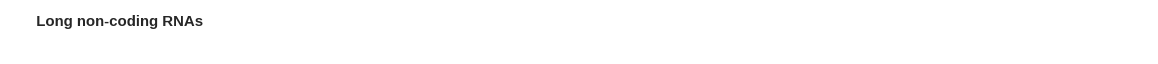

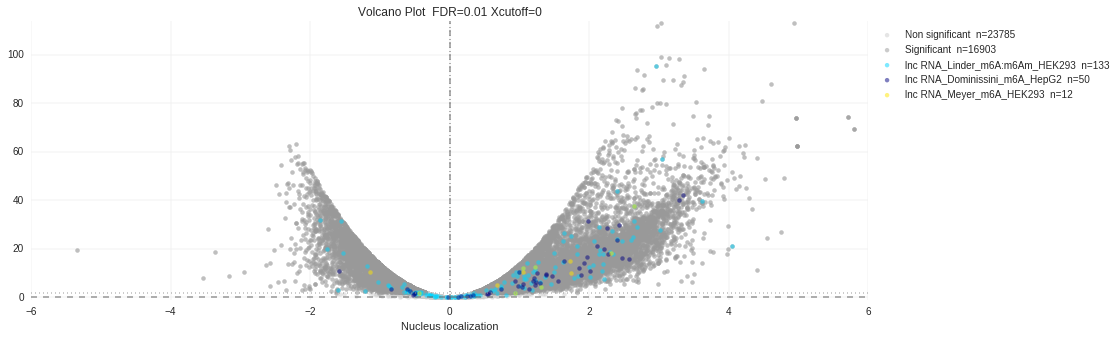

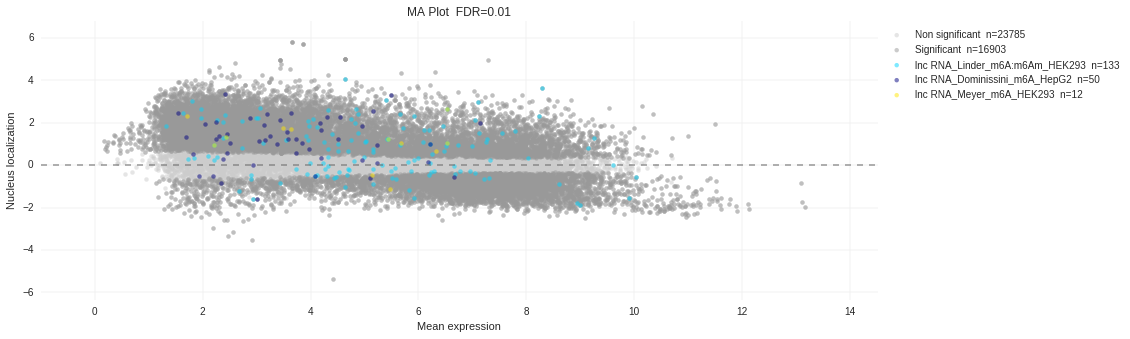

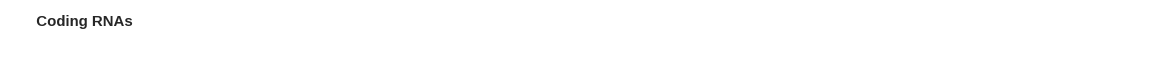

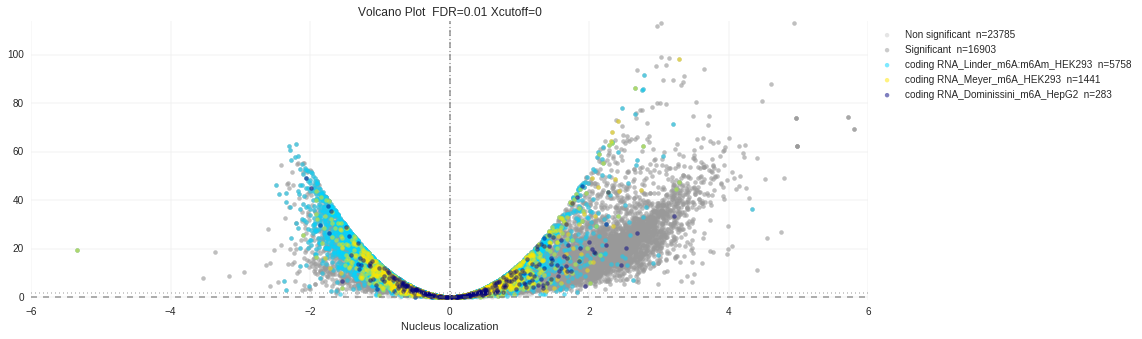

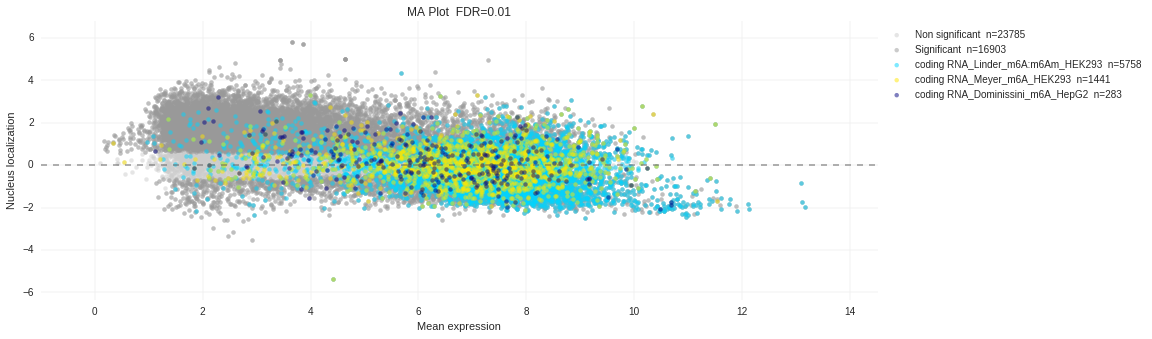

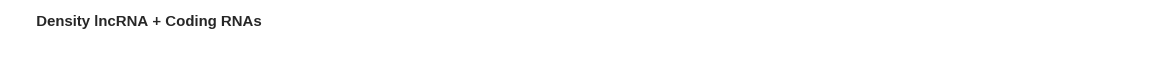

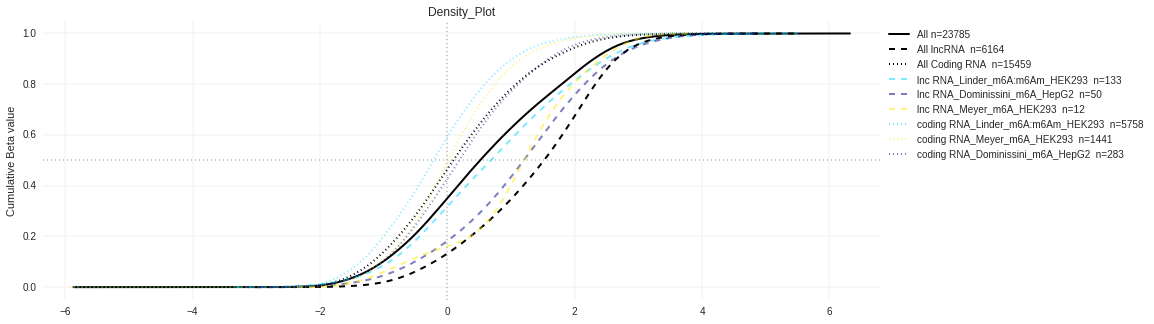

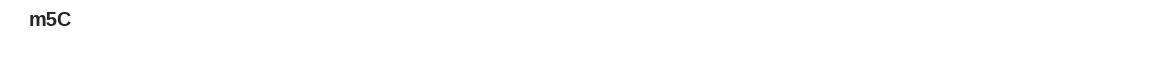

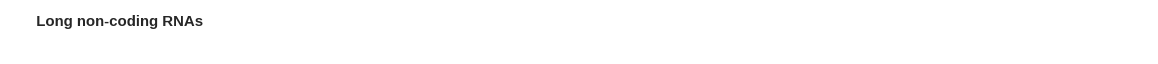

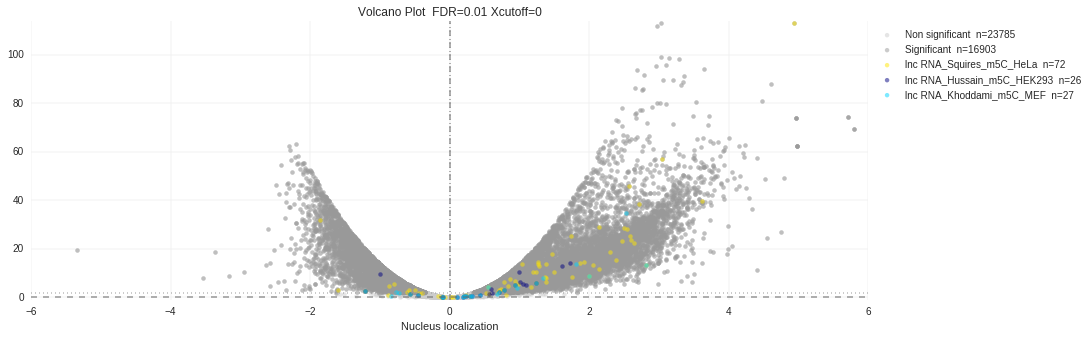

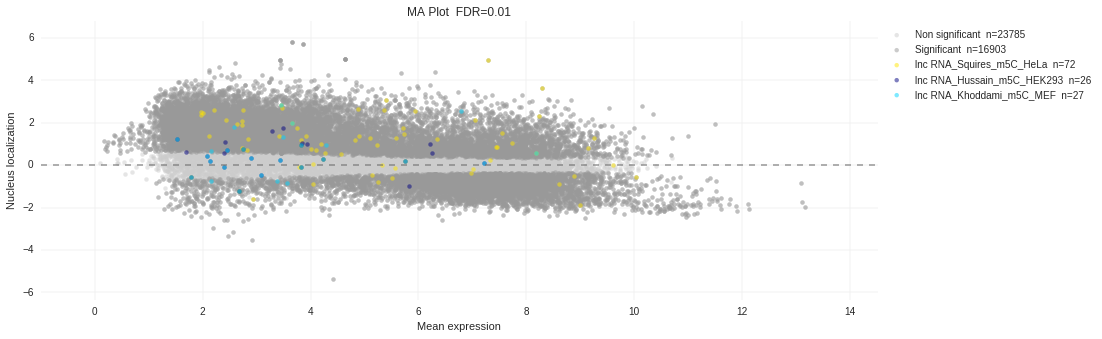

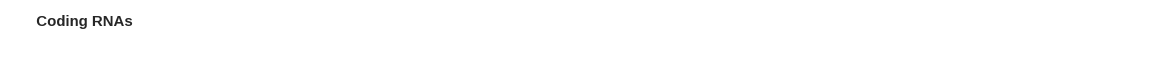

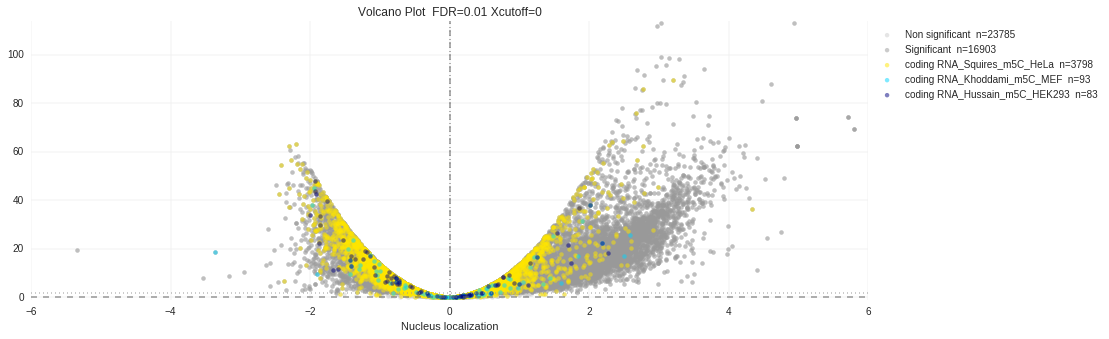

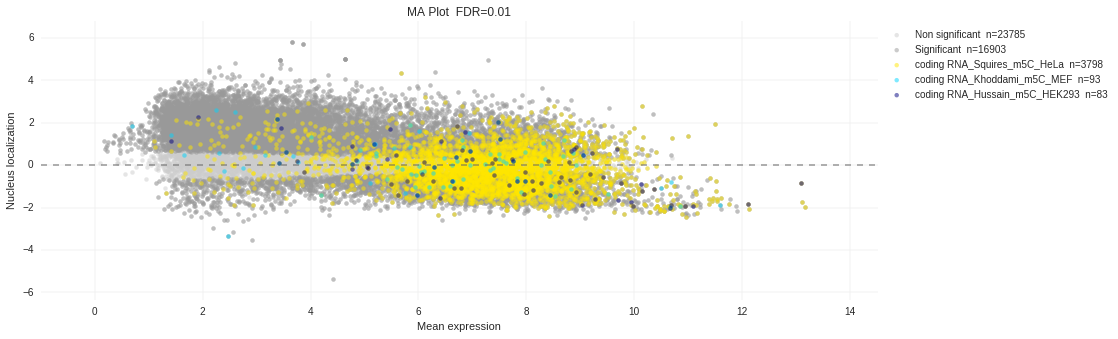

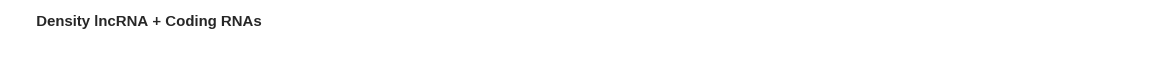

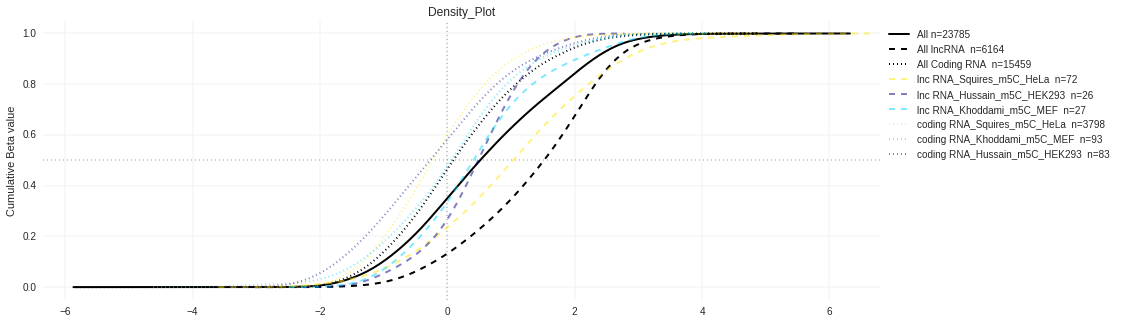

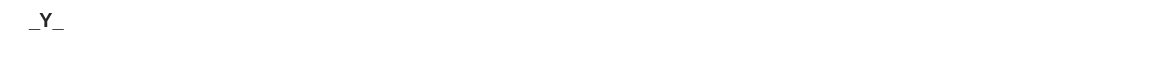

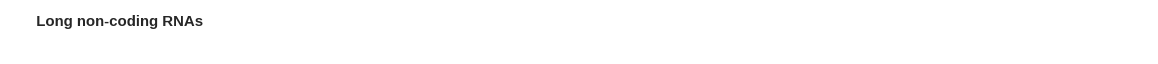

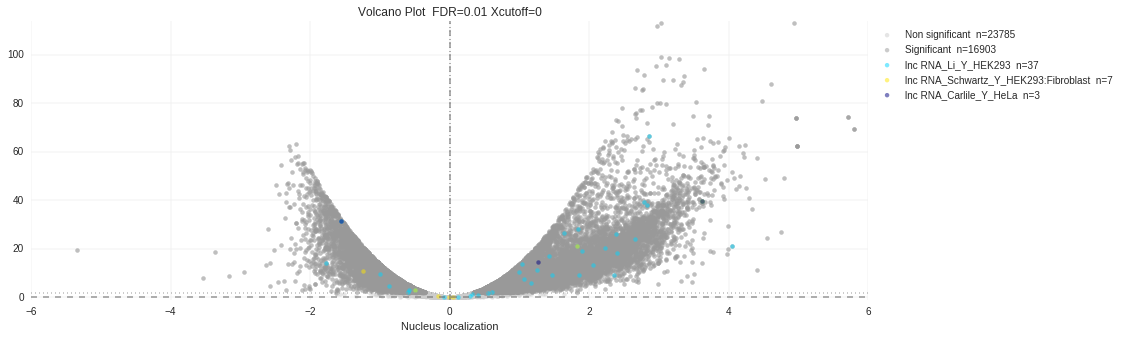

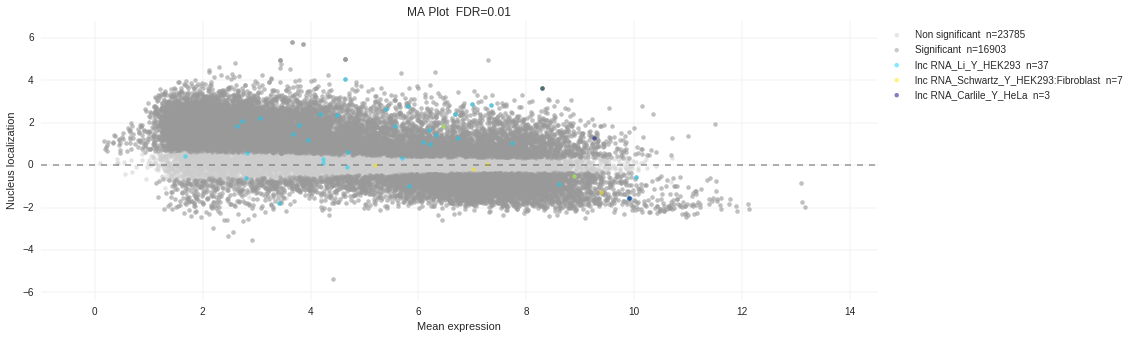

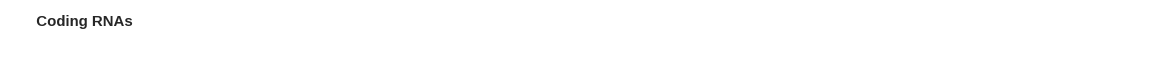

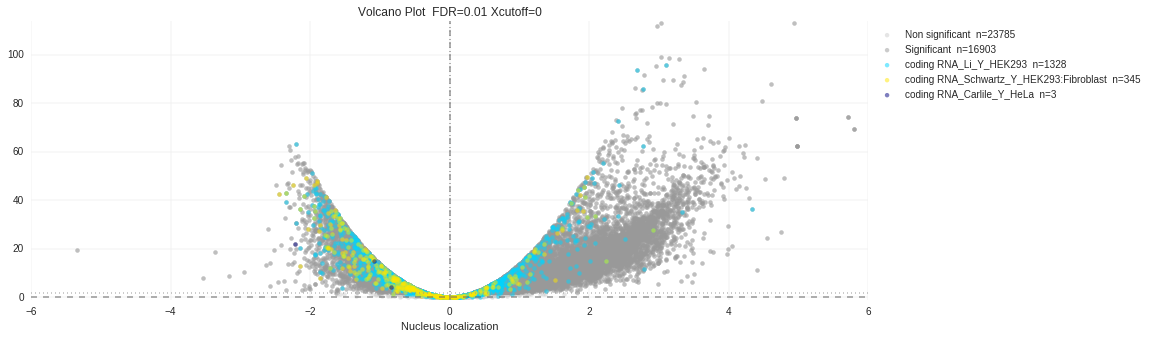

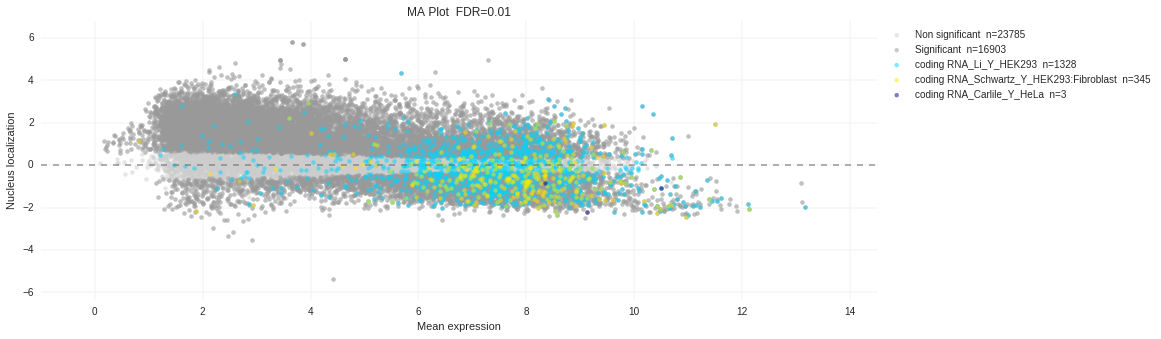

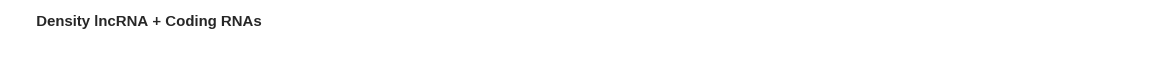

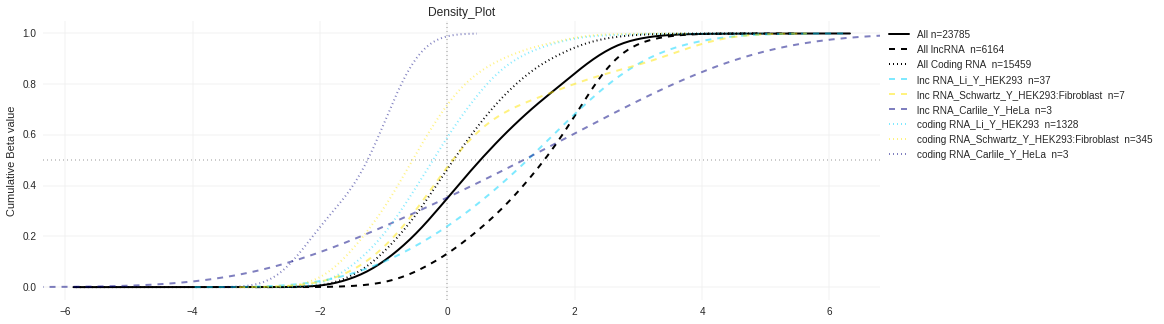

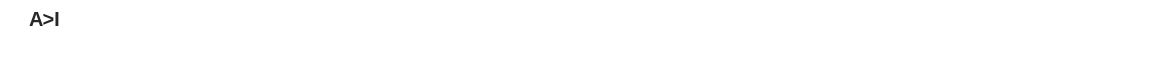

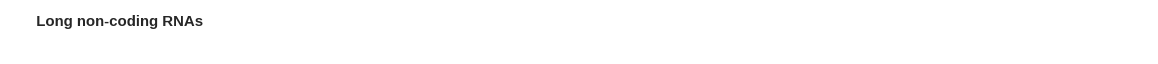

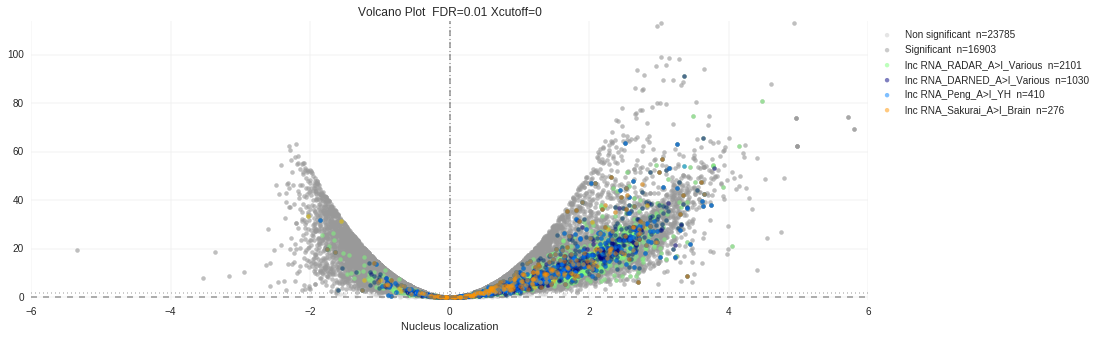

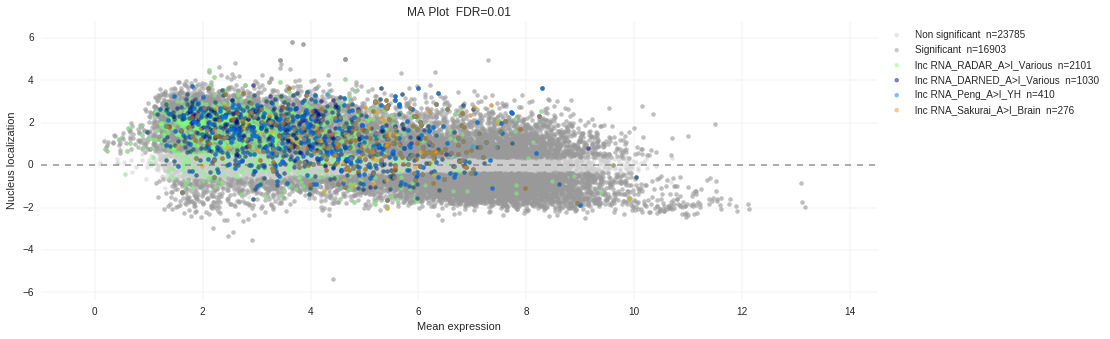

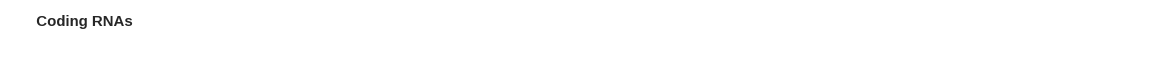

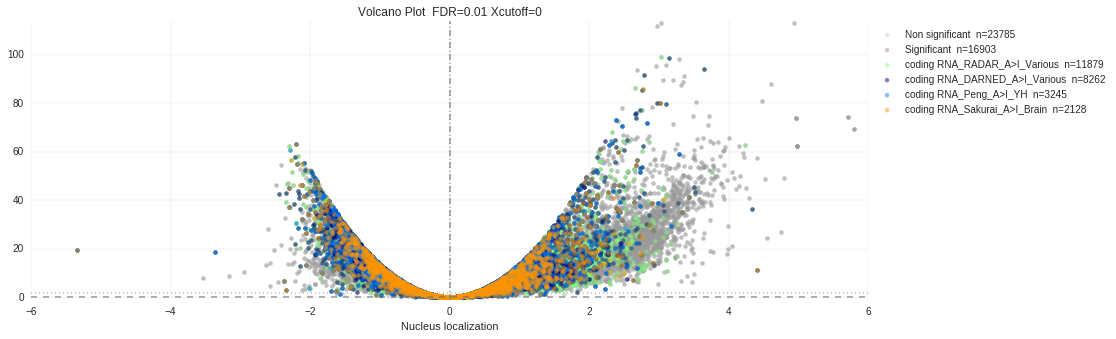

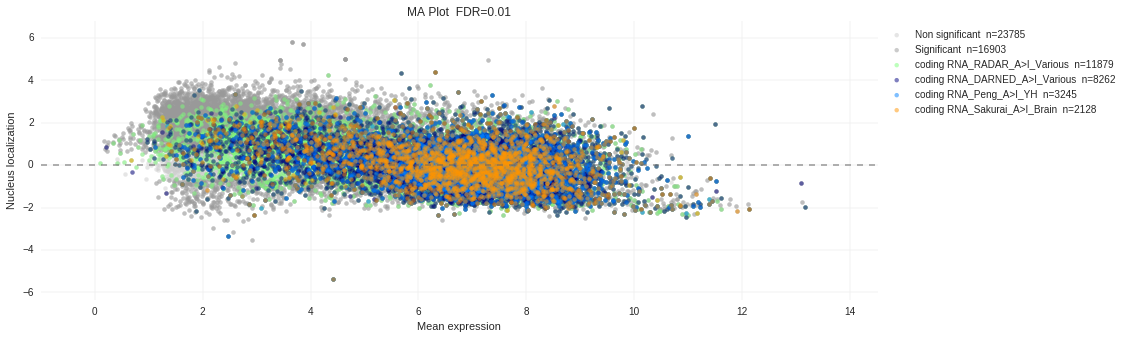

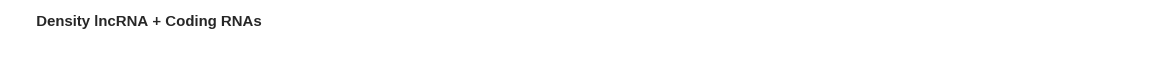

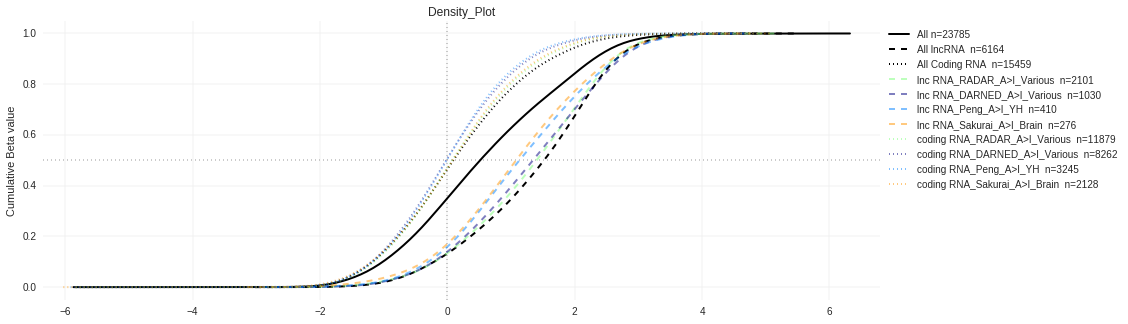

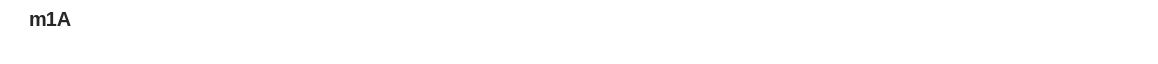

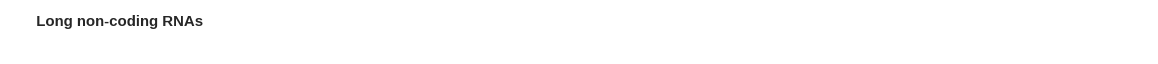

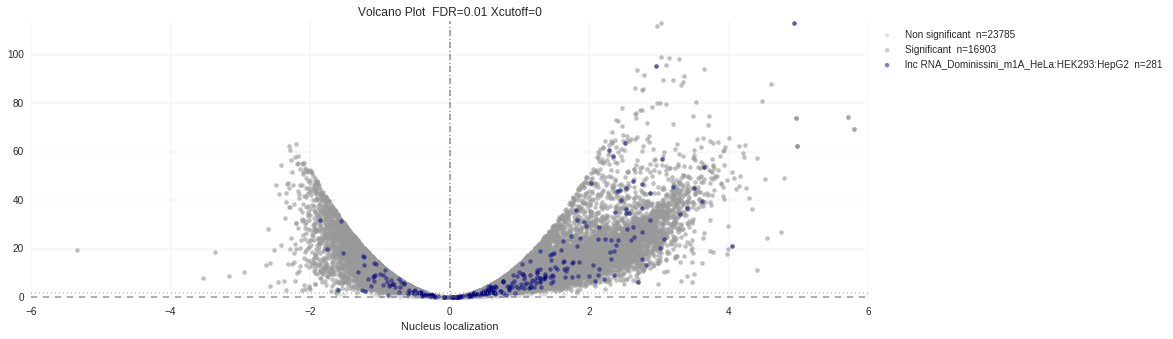

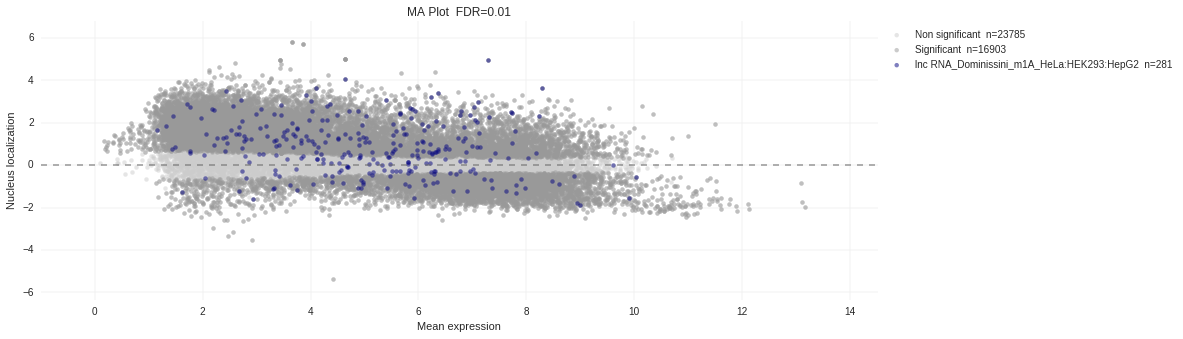

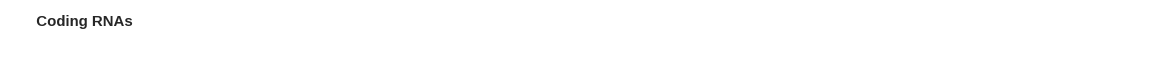

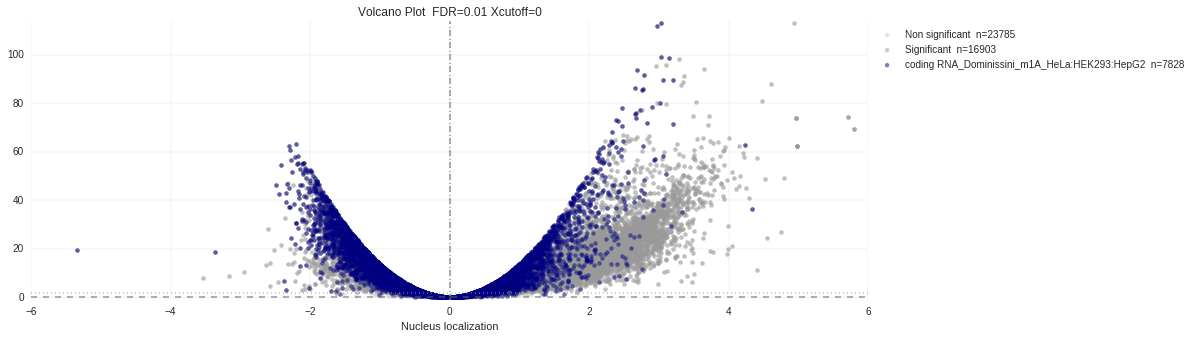

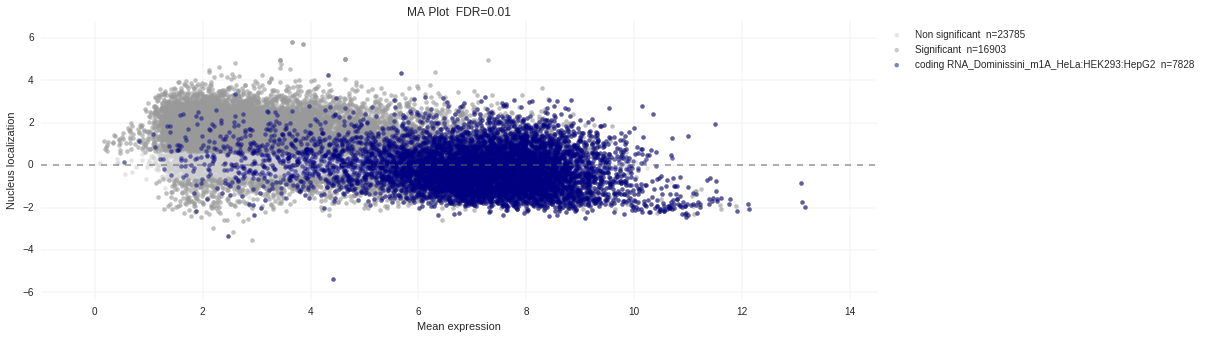

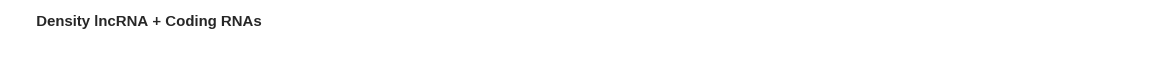

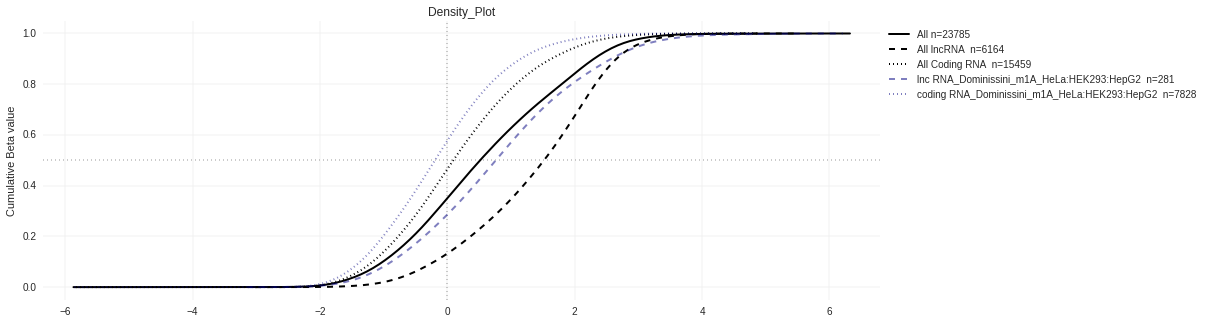

In [2]:
# Define the categories of lnc and coding RNA
lncRNA_types = ["lincRNA", "antisense", "TEC", "sense_intronic", "processed_transcript", "sense_overlapping", "3prime_overlapping_ncrna", "non_coding", "bidirectional_promoter_lncrna", "macro_lncRNA"]
coding_RNA_types = ["protein_coding", "transcribed_processed_pseudogene", "transcribed_unitary_pseudogene", "translated_unprocessed_pseudogene"]

# Read the main data
df = pd.read_table("./Localisation_Original_Datasets/Djebali-ENCODE/sleuth/gene_allRNA/ALL/localizationnucleus_wald_test.tsv")

# Deal with the 2 rnatypes
gene_df = pd.read_table( "../../Reference_Annotation/gencode_v24_gene.tsv")
# Subsetting coding genes
coding_RNA_types = ["protein_coding", "transcribed_processed_pseudogene", "transcribed_unitary_pseudogene", "translated_unprocessed_pseudogene"]
codingRNA_id = gene_df.ID[(gene_df.gene_type.isin(coding_RNA_types))]
# Subsetting lncRNA genes
lncRNA_types = ["lincRNA", "antisense", "TEC", "sense_intronic", "processed_transcript", "sense_overlapping", "3prime_overlapping_ncrna", "non_coding", "bidirectional_promoter_lncrna", "macro_lncRNA"]
lncRNA_id = gene_df.ID[(gene_df.gene_type.isin(lncRNA_types))]

hl_types = [
    {"target_id":lncRNA_id, "label":"All lncRNA", "linestyle":'--', "color":"black"},
    {"target_id":codingRNA_id, "label":"All Coding RNA", "linestyle":':', "color":"black"},]

for modif in ["m6A", "m5C", "_Y_", "A>I", "m1A"]:  
    PTM_dataset_list = sorted(glob("./PTM_Annotated_Datasets/*{}*_hg38_cleaned_gencode_v24_uniq-gene.csv".format(modif)))
    hl_lncRNA = []
    hl_codingRNA = []
    color = get_color_list(len(PTM_dataset_list), "jet")
    
    for fp in PTM_dataset_list:
        PTM_df = pd.read_table(fp, names=["target_id", "gene_name", "gene_type", "count"])
        c = next(color)
        
        # lncRNA
        hl_lncRNA.append({
                "target_id": PTM_df.target_id[(PTM_df.target_id.isin(lncRNA_id))],
                "label":"lnc RNA_{}".format(file_name(fp).split("_hg38_")[0]),
                "alpha":0.5, "linestyle":'--', "color":c})
        
        # codingRNA
        hl_codingRNA.append({
                "target_id": PTM_df.target_id[(PTM_df.target_id.isin(codingRNA_id))],
                "label":"coding RNA_{}".format(file_name(fp).split("_hg38_")[0]),
                "alpha":0.5, "linestyle":':', "color":c})
    
    plot_text(modif, align="left", fontsize=20, fontweight="bold")
    
    # lncRNA
    hl_lncRNA.sort(key=lambda x: len(x["target_id"]), reverse=True)
    plot_text("  Long non-coding RNAs", align="left", fontsize=15, fontweight="bold")
    volcano_plot (df=df, highlight_list=hl_lncRNA, X="b", Y="qval", FDR=0.01, X_cutoff=0, figsize=[15,5], xlabel = "Nucleus localization", sig_color="0.6", non_sig_color="0.8", xlim=[-6,6], alpha=0.5)
    MA_plot (df=df, highlight_list=hl_lncRNA, X="mean_obs", Y="b", FDR=0.01, FDR_col="qval", figsize=[15,5], xlabel="Mean expression", ylabel="Nucleus localization", sig_color="0.6", non_sig_color="0.8", alpha=0.5)
    
    # codingRNA
    hl_codingRNA.sort(key=lambda x: len(x["target_id"]), reverse=True)
    plot_text("  Coding RNAs", align="left", fontsize=15, fontweight="bold")
    volcano_plot (df=df, highlight_list=hl_codingRNA, X="b", Y="qval", FDR=0.01, X_cutoff=0, figsize=[15,5], xlabel = "Nucleus localization", sig_color="0.6", non_sig_color="0.8", xlim=[-6,6], alpha=0.5)
    MA_plot (df=df, highlight_list=hl_codingRNA, X="mean_obs", Y="b", FDR=0.01, FDR_col="qval", figsize=[15,5], xlabel="Mean expression", ylabel="Nucleus localization", sig_color="0.6", non_sig_color="0.8", alpha=0.5)
    
    # Density plot with both RNA types
    HL = hl_types + hl_lncRNA + hl_codingRNA
    plot_text("  Density lncRNA + Coding RNAs", align="left", fontsize=15, fontweight="bold")
    density_plot(df, "b", figsize=[15,5], ylabel="Cumulative Beta value", highlight_list= HL, cumulative = True)

        

---
## Comparison lncRNA PTM datasets / lncRNA Localization at transcript level


**Considering the methods used by most of the genome wide PTM investigation I don't know if it is possible to determine the transcript of origin of the modified RNA ?? Possibility to use Kallisto or other methods eventually perform a transcript level analysis.**
*
*


###  Summary dataset 2
*
*